In [1]:
###### %matplotlib inline
# %config InlineBackend.figure_format = 'retina'

# convolutional autoencoder in keras

import os
#os.environ["KERAS_BACKEND"] = "tensorflow"

from __future__ import print_function
from keras.models import Model
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, BatchNormalization, LeakyReLU, AveragePooling2D
from keras.datasets import mnist
from keras.regularizers import l1
from keras.optimizers import Adam
from keras import backend as K

import matplotlib.pyplot as plt
# %matplotlib inline

from keras.datasets import mnist 

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# utility function for showing images
def show_imgs(x_test, decoded_imgs, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i+1)
        plt.imshow(x_test[i].reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if decoded_imgs is not None:
            ax = plt.subplot(2, n, i+ 1 +n)
            plt.imshow(decoded_imgs[i].reshape(28,28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()

### Create input

(x_all, y_all), (x_all_test, y_all_test) = mnist.load_data()

x_all = x_all.astype('float32')/255. # 0-1.に変換
x_all_test = x_all_test.astype('float32')/255.

###


'''
x_9_list=[]
for i in range(len(y_all)):
    if (y_all[i] == 9):
        x_9_list.append(x_all[i])
x_9=np.asarray(x_9_list[:5000])
x_9_list_test=[]
for i in range(len(y_all_test)):
    if (y_all_test[i] == 9):
        x_9_list_test.append(x_all_test[i])
x_9_test=np.asarray(x_9_list_test[:500])
'''
x_9=x_all
x_9_test=x_all_test



###

x_6_list=[]
for i in range(len(y_all)):
    if (y_all[i] == 6):
        x_6_list.append(x_all[i])
x_6=np.asarray(x_6_list[:5000])
x_6_list_test=[]
for i in range(len(y_all_test)):
    if (y_all_test[i] == 6):
        x_6_list_test.append(x_all_test[i])
x_6_test=np.asarray(x_6_list_test[:500])

###

x_8_list=[]
for i in range(len(y_all)):
    if (y_all[i] == 8):
        x_8_list.append(x_all[i])
x_8=np.asarray(x_8_list[:5000])
x_8_list_test=[]
for i in range(len(y_all_test)):
    if (y_all_test[i] == 8):
        x_8_list_test.append(x_all_test[i])
x_8_test=np.asarray(x_8_list_test[:500])

###

x_9 = np.reshape(x_9, (len(x_9), 28, 28, 1))
x_9_test = np.reshape(x_9_test, (len(x_9_test), 28, 28, 1))

x_6 = np.reshape(x_6, (len(x_6), 28, 28, 1))
x_6_test = np.reshape(x_6_test, (len(x_6_test), 28, 28, 1))

x_8 = np.reshape(x_8, (len(x_8), 28, 28, 1))
x_8_test = np.reshape(x_8_test, (len(x_8_test), 28, 28, 1))

print(x_9.shape,x_6.shape,x_8.shape)

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(60000, 28, 28, 1) (5000, 28, 28, 1) (5000, 28, 28, 1)


In [2]:
### pretrain1
    
input_img = Input(shape=(28, 28,1)) # 1ch=black&white, 28 x 28

train1_norm=BatchNormalization(axis=-1, name='t1n')(input_img)
LeakyReLU(alpha=0.3)
train1_c1 = Conv2D(16, (3, 3), activation='relu', padding='same', name='t1c1')(train1_norm)
train1_decoded = Conv2DTranspose(1, (3, 3), activation='relu', padding='same', name='t1tc1')(train1_c1)

train1_autoencoder = Model(input_img, train1_decoded)
train1_autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

train1_autoencoder.fit(x_9, x_9, epochs=5, batch_size=20,
               shuffle=True, validation_data=(x_9_test, x_9_test), verbose=1)

### pretrain2

creator_train2 = Model(input_img, train1_c1)
creator_train2.get_layer("t1c1").set_weights(train1_autoencoder.get_layer('t1c1').get_weights())

input_train2 = creator_train2.predict(x_9)

print(input_train2.shape)

#---

input_img_train2 = Input(shape=(28, 28, 16))
train2_p1 = MaxPooling2D(pool_size=(2, 2), name='t2p1')(input_img_train2)
train2_c1 = Conv2D(8, (3, 3), activation='relu', padding='same', name='t2c1')(train2_p1)
train2_tc1 = Conv2DTranspose(16, (3, 3), activation='relu', padding='same', name='t2tc1')(train2_c1)
train2_decoded = UpSampling2D(size=(2, 2), name='t3u1')(train2_tc1)

train2_autoencoder = Model(input_img_train2, train2_decoded)
train2_autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

train2_autoencoder.fit(input_train2, input_train2, epochs=5, batch_size=20, verbose=1)

### pretrain3

creator_train3 = Model(input_img_train2, train2_c1)
creator_train3.get_layer("t2c1").set_weights(train2_autoencoder.get_layer('t2c1').get_weights())

input_train3 = creator_train3.predict(input_train2)

print(input_train2.shape)

#---

input_img_train3 = Input(shape=(14, 14, 8))
train3_p1 = MaxPooling2D(pool_size=(2, 2), name='t3p1')(input_img_train3)
train3_c1 = Conv2D(4, (3, 3), activation='relu', padding='same', name='t3c1')(train3_p1)
train3_tc1 = Conv2DTranspose(8, (3, 3), activation='relu', padding='same', name='t3tc1')(train3_c1)
train3_decoded = UpSampling2D(size=(2, 2), name='t3u1')(train3_tc1)

train3_autoencoder = Model(input_img_train3, train3_decoded)
train3_autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

train3_autoencoder.fit(input_train3, input_train3, epochs=5, batch_size=20, verbose=1)


Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 47s 781us/step - loss: 7.0955e-04 - val_loss: 2.1466e-04
Epoch 2/5
60000/60000 [==============================] - 47s 778us/step - loss: 3.5341e-04 - val_loss: 3.8054e-04
Epoch 3/5
60000/60000 [==============================] - 47s 783us/step - loss: 3.0847e-04 - val_loss: 3.6351e-04
Epoch 4/5
60000/60000 [==============================] - 47s 778us/step - loss: 2.5152e-04 - val_loss: 2.8259e-05
Epoch 5/5
60000/60000 [==============================] - 47s 779us/step - loss: 2.2875e-04 - val_loss: 1.3030e-04
(60000, 28, 28, 16)
Epoch 1/5
60000/60000 [==============================] - 80s 1ms/step - loss: 0.0032
Epoch 2/5
60000/60000 [==============================] - 80s 1ms/step - loss: 0.0025
Epoch 3/5
60000/60000 [==============================] - 81s 1ms/step - loss: 0.0024
Epoch 4/5
60000/60000 [==============================] - 84s 1ms/step - loss: 0.0024
Epoch 5/5
60000/6000

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 107s 2ms/step - loss: 0.0128 - val_loss: 0.0089
Epoch 2/5
60000/60000 [==============================] - 106s 2ms/step - loss: 0.0083 - val_loss: 0.0069
Epoch 3/5
60000/60000 [==============================] - 112s 2ms/step - loss: 0.0071 - val_loss: 0.0058
Epoch 4/5
60000/60000 [==============================] - 107s 2ms/step - loss: 0.0065 - val_loss: 0.0056
Epoch 5/5
60000/60000 [==============================] - 106s 2ms/step - loss: 0.0061 - val_loss: 0.0052


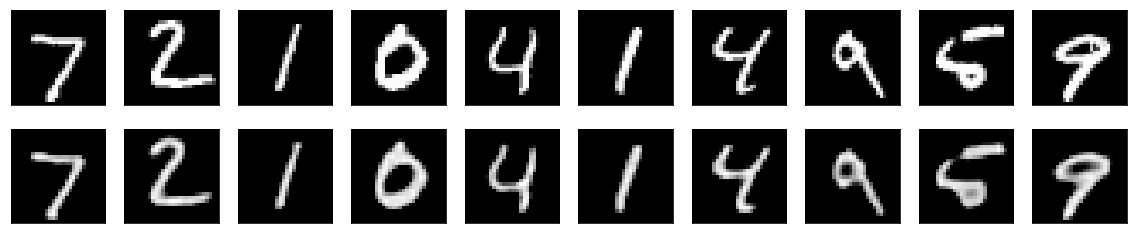

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
n (BatchNormalization)       (None, 28, 28, 1)         4         
_________________________________________________________________
c1 (Conv2D)                  (None, 28, 28, 16)        160       
_________________________________________________________________
p1 (MaxPooling2D)            (None, 14, 14, 16)        0         
_________________________________________________________________
c2 (Conv2D)                  (None, 14, 14, 8)         1160      
_________________________________________________________________
p2 (MaxPooling2D)            (None, 7, 7, 8)           0         
_________________________________________________________________
c3 (Conv2D)                  (None, 7, 7, 4)           292       
__________

In [3]:
### unroll

input_img = Input(shape=(28, 28,1)) # 1ch=black&white, 28 x 28

norm=BatchNormalization(axis=-1, name='n', weights=train1_autoencoder.get_layer("t1n").get_weights())(input_img)
c1 = Conv2D(16, (3, 3), activation='relu', padding='same', name='c1', weights=train1_autoencoder.get_layer("t1c1").get_weights())(norm)
p1 = MaxPooling2D(pool_size=(2, 2), name='p1')(c1)
c2 = Conv2D(8, (3, 3), activation='relu', padding='same', name='c2', weights=train2_autoencoder.get_layer("t2c1").get_weights())(p1)
p2 = MaxPooling2D(pool_size=(2, 2), name='p2')(c2)
encoded = Conv2D(4, (3, 3), activation='relu', padding='same', name='c3', weights=train3_autoencoder.get_layer("t3c1").get_weights())(p2)
tc3 = Conv2DTranspose(8, (3, 3), activation='relu', padding='same', name='tc3', weights=train3_autoencoder.get_layer("t3tc1").get_weights())(encoded)
u2 = UpSampling2D(size=(2, 2), name='u2')(tc3)
tc2 = Conv2DTranspose(16, (3, 3), activation='relu', padding='same', name='tc2', weights=train2_autoencoder.get_layer("t2tc1").get_weights())(u2)
u1 = UpSampling2D(size=(2, 2), name='u1')(tc2)
decoded = Conv2DTranspose(1, (3, 3), activation='relu', padding='same', name='tc1', weights=train1_autoencoder.get_layer("t1tc1").get_weights())(u1)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

### finetune

autoencoder.fit(x_9, x_9, epochs=5, batch_size=20,
            shuffle=True, validation_data=(x_9_test, x_9_test), verbose=1)

### plot

decoded_imgs = autoencoder.predict(x_9_test)
show_imgs(x_9_test,decoded_imgs)

print(autoencoder.summary())

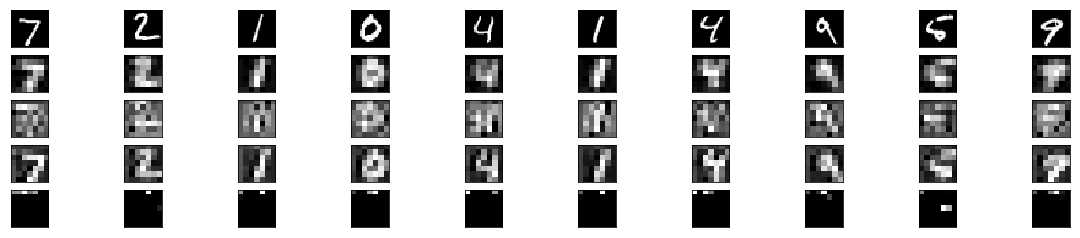

In [4]:
autoencoder_show_hidden = Model(input_img, encoded)
encoded_imgs = autoencoder_show_hidden.predict(x_9_test)

def show_hidden(x_test, encoded_imgs, n=10):
    
    en0=np.zeros((encoded_imgs.shape[0],encoded_imgs.shape[1],encoded_imgs.shape[2]))
    en1=np.zeros((encoded_imgs.shape[0],encoded_imgs.shape[1],encoded_imgs.shape[2]))
    en2=np.zeros((encoded_imgs.shape[0],encoded_imgs.shape[1],encoded_imgs.shape[2]))
    en3=np.zeros((encoded_imgs.shape[0],encoded_imgs.shape[1],encoded_imgs.shape[2]))

    for i in range(encoded_imgs.shape[0]):
        for j in range(encoded_imgs.shape[1]):
            for k in range(encoded_imgs.shape[2]):
                en0[i][j][k]=encoded_imgs[i][j][k][0]
                en1[i][j][k]=encoded_imgs[i][j][k][1]
                en2[i][j][k]=encoded_imgs[i][j][k][2]
                en3[i][j][k]=encoded_imgs[i][j][k][3]
    
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(5, n, i+1)
        plt.imshow(x_test[i].reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if decoded_imgs is not None:
            ax = plt.subplot(5, n, i+ 1 +n)
            plt.imshow(en0[i].reshape(7,7))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
            ax = plt.subplot(5, n, i+ 1 +2*n)
            plt.imshow(en1[i].reshape(7,7))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
            ax = plt.subplot(5, n, i+ 1 +3*n)
            plt.imshow(en2[i].reshape(7,7))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
            ax = plt.subplot(5, n, i+ 1 +4*n)
            plt.imshow(en3[i].reshape(7,7))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()

show_hidden(x_9_test, encoded_imgs)

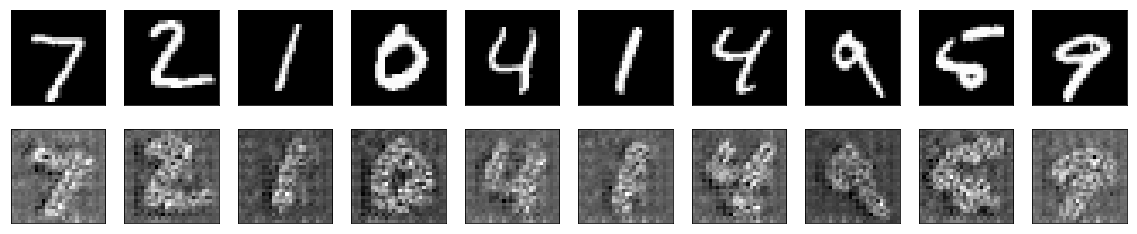

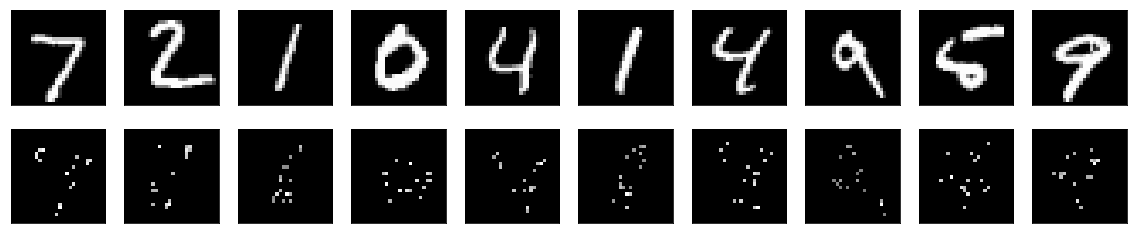

In [60]:
layer_name = 'c3'

layer_dict = dict([(layer.name, layer) for layer in autoencoder.layers[1:]])

filter_index = 0  # can be any integer from 0 to 511, as there are 512 filters in that layer

# build a loss function that maximizes the activation
# of the nth filter of the layer considered
layer_output = layer_dict[layer_name].output
loss = K.mean(layer_output[:, :, :, filter_index])

# compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, input_img)[0]

# normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

# this function returns the loss and grads given the input picture
iterate = K.function([input_img], [loss, grads])

it = iterate([x_9_test])
show_imgs(x_9_test,it[1])

it_temp=np.zeros((10000,28,28))
for i in range(10000):
    q=np.percentile(it[1][i],98)
    for j in range(28):
        for k in range(28):
            if(it[1][i][j][k]>q):
               it_temp[i][j][k]=it[1][i][j][k]
            
show_imgs(x_9_test,it_temp)

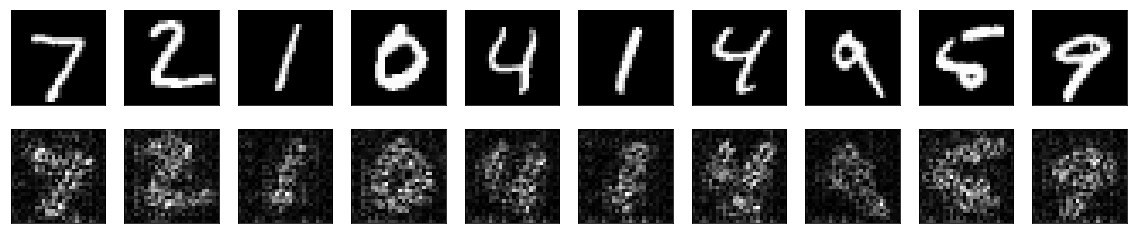

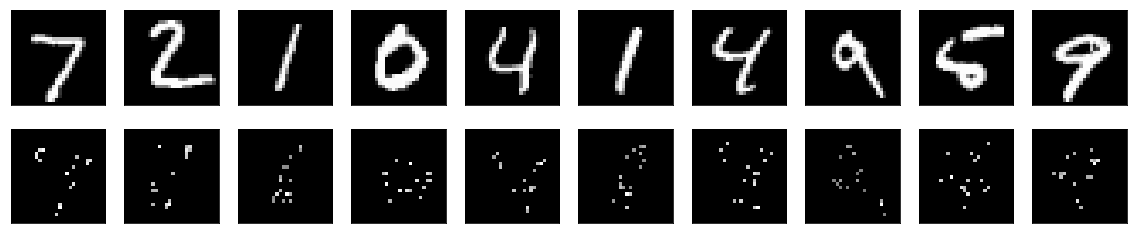

In [62]:
def getMaxGrads(input_set, model, layer_name, nof):
    
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    
    out = np.zeros((len(input_set),len(input_set[0]),len(input_set[0][0])))

    for i in range(nof):
        filter_index = i  # can be any integer from 0 to 511, as there are 512 filters in that layer

        layer_output = layer_dict[layer_name].output
        loss = K.mean(layer_output[:, :, :, filter_index])

        # compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, input_img)[0]

        # normalization trick: we normalize the gradient
        grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)  ### normalize? ... later

        # this function returns the loss and grads given the input picture
        iterate = K.function([input_img], [loss, grads])

        it = iterate([input_set])
        
        len1=len(out)
        len2=len(out[0])
        len3=len(out[0][0])
        
        for j in range(len1):
            for k in range(len2):
                for l in range(len3):
                    if abs(it[1][j][k][l]) > out[j][k][l]:   #abs()?
                       out[j][k][l]=abs(it[1][j][k][l])
                        
        return out
    
out = getMaxGrads(x_9_test, autoencoder, 'c3', 4)
        
show_imgs(x_9_test,out)

it_temp=np.zeros((10000,28,28))
for i in range(10000):
    q=np.percentile(out[i],98)
    for j in range(28):
        for k in range(28):
            if(out[i][j][k]>q):
               it_temp[i][j][k]=out[i][j][k]
            
show_imgs(x_9_test,it_temp)

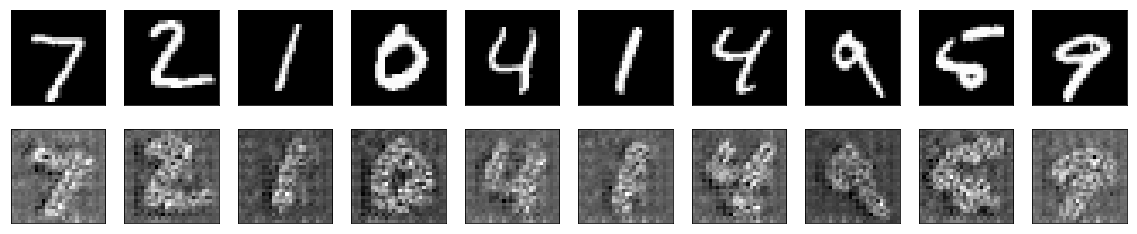